# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-25 14:19:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  55.2MB/s    in 41s     

2023-02-25 14:20:12 (26.3 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dog-image-data"
role = sagemaker.get_execution_role()
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))
print(inputs)

input spec (in this case, just an S3 path): s3://sagemaker-us-east-2-713672480371/dog-image-data
s3://sagemaker-us-east-2-713672480371/dog-image-data


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16,32,64]),
    "epochs": IntegerParameter(2,4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
from sagemaker.pytorch import PyTorch

#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [9]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................!


In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-25 14:42:14 Starting - Preparing the instances for training
2023-02-25 14:42:14 Downloading - Downloading input data
2023-02-25 14:42:14 Training - Training image download completed. Training in progress.
2023-02-25 14:42:14 Uploading - Uploading generated training model
2023-02-25 14:42:14 Completed - Resource reused by training job: pytorch-training-230225-1435-004-83f3d71e


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '3',
 'lr': '0.004953000966763836',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-25-14-35-54-986"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-713672480371/pytorch-training-2023-02-25-14-35-54-986/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {
    "lr": "0.0010569163218645224",
    "batch-size": "64",
    "epochs":  "2"
}

# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs, ProfilerRule
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)

In [12]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version="py3",
    framework_version="1.4",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    
)

estimator.fit({"train": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dogImageClassifier-2023-02-25-14-45-57-619


2023-02-25 14:45:58 Starting - Starting the training job...
2023-02-25 14:46:23 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2023-02-25 14:46:58 Downloading - Downloading input data......
2023-02-25 14:47:53 Training - Downloading the training image...
2023-02-25 14:48:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-25 14:48:13,941 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-25 14:48:13,944 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-02-25 14:48:13,955 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-25 14:48:13,957 sagemaker_pytorch_container.training INFO     Invoking us

In [13]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-02-25 15:12:34.802 datascience-1-0-ml-t3-medium-b3043d3e6163713f99726df4a911:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Training jobname: dogImageClassifier-2023-02-25-14-45-57-619
Region: us-east-2
[2023-02-25 15:12:34.872 datascience-1-0-ml-t3-medium-b3043d3e6163713f99726df4a911:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-713672480371/dogImageClassifier-2023-02-25-14-45-57-619/debug-output
[2023-02-25 15:12:36.361 datascience-1-0-ml-t3-medium-b3043d3e6163713f99726df4a911:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-25 15:12:37.389 datascience-1-0-ml-t3-medium-b3043d3e6163713f99726df4a911:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gra

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


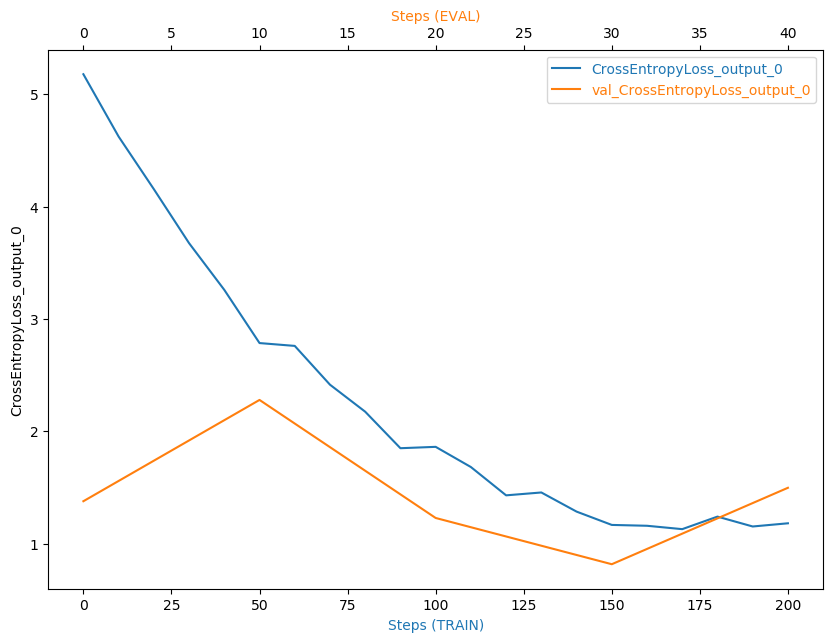

In [14]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [15]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-2-713672480371/dogImageClassifier-2023-02-25-14-45-57-619/rule-output


In [16]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2023-02-25 15:12:19     329711 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-25 15:12:18     171084 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-25 15:12:15        192 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-25 15:12:15        200 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-25 15:12:15        126 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-25 15:12:15        127 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-25 15:12:15        199 dogImageClassifier-2023-02-25-14-45-57-619/rule-output/ProfilerReport/profiler-outp

In [18]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


## Model Deploying

In [43]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


model_location='s3://sagemaker-us-east-2-713672480371/dogImageClassifier-2023-02-25-15-36-25-545/model.tar.gz'

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
role=get_execution_role()
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='model_endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-25-17-02-29-922
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-25-17-02-30-593
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-25-17-02-30-593


-----!

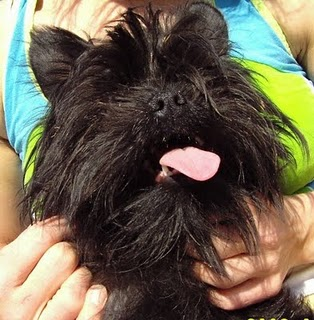

In [49]:
from PIL import Image
import io
# TODO: Run an prediction on the endpoint
with open("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "rb") as f:
    payload = f.read()
Image.open(io.BytesIO(payload))


In [50]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response


[[0.14523878693580627,
  0.07040271162986755,
  -0.0059049176052212715,
  0.045313552021980286,
  0.22860173881053925,
  0.021303344517946243,
  -0.014775079675018787,
  0.14999166131019592,
  -0.24571523070335388,
  0.029382478445768356,
  0.13325254619121552,
  0.1447446346282959,
  -0.11866465210914612,
  0.14337670803070068,
  0.17000041902065277,
  0.009656589478254318,
  0.13290543854236603,
  -0.023674624040722847,
  -0.039080750197172165,
  0.043350160121917725,
  0.12088879942893982,
  -0.06563533842563629,
  0.12400940805673599,
  0.06534630805253983,
  -0.18278691172599792,
  -0.13745707273483276,
  0.059752803295850754,
  -0.26044636964797974,
  0.16554389894008636,
  -0.008840815164148808,
  0.051016975194215775,
  0.14977066218852997,
  -0.11417864263057709,
  0.05092186480760574,
  -0.019825680181384087,
  0.06517897546291351,
  -0.06889734417200089,
  0.008734015747904778,
  0.1436401754617691,
  -0.011980141513049603,
  0.07932580262422562,
  0.09312983602285385,
  -0.

In [52]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-02-25-17-02-30-593
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-02-25-17-02-30-593
